<a href="https://colab.research.google.com/github/bailejor/SAMSHA_Transfer_Learning/blob/main/General_sub_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications import ResNet50
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing import image_dataset_from_directory
from keras.models import Model
from keras.optimizers import Adam, SGD
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, fbeta_score, balanced_accuracy_score, precision_recall_curve
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from matplotlib import pyplot


In [ ]:
!unzip /content/drive/MyDrive/ValImages.nosync.zip

In [ ]:
!unzip /content/drive/MyDrive/TrainImages_70.nosync.zip

Found 435974 files belonging to 2 classes.
Using 305182 files for training.
Found 435974 files belonging to 2 classes.
Using 130792 files for validation.
Found 93424 files belonging to 2 classes.


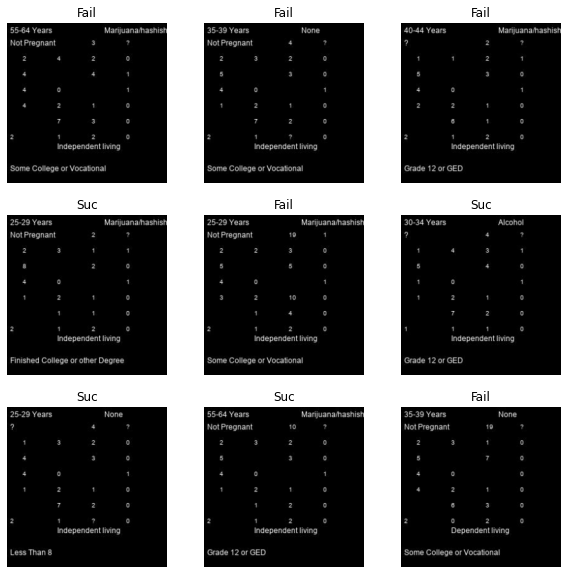

In [4]:



train_dataset = image_dataset_from_directory(
    '/content/TrainImages_70.nosync',
    validation_split=0.3,
    subset="training",
    seed=6,
    image_size=(250, 250),
    batch_size=32,
    shuffle = True,
    color_mode = 'rgb'
)

validation_dataset = image_dataset_from_directory(
    '/content/TrainImages_70.nosync',
    validation_split=0.3,
    subset="validation",
    seed=6,
    image_size=(250, 250),
    batch_size=32,
    shuffle = True,
    color_mode = 'rgb'
)




test_dataset = image_dataset_from_directory('/content/ValImages.nosync', image_size=(250, 250), color_mode='rgb', batch_size = 32,  shuffle=False)

class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+ 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')


In [5]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
         ModelCheckpoint(filepath='/content/drive/MyDrive/best_model_transfer_noweights.h5', monitor='val_loss', save_best_only=True)]

input_t = keras.Input(shape=(250, 250, 3))
base_model = keras.applications.ResNet50(input_tensor=input_t, include_top=False, weights='imagenet') 
base_model.trainable = False



inputs = keras.Input(shape=(250, 250, 3))
x = base_model(inputs, training = False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

model.compile(loss = keras.losses.BinaryCrossentropy(from_logits=True), optimizer = keras.optimizers.Adam(),
              metrics=[keras.metrics.Precision(), keras.metrics.BinaryAccuracy(), keras.metrics.TruePositives(), keras.metrics.TrueNegatives(), keras.metrics.FalseNegatives(), keras.metrics.FalsePositives()])



model.fit(train_dataset, epochs = 15, verbose = 1, validation_data = validation_dataset, callbacks = callbacks)


94773248/94765736 [==============================] - 1s 0us/step
Epoch 1/15
9537/9537 [==============================] - 1896s 197ms/step - loss: 0.5924 - precision: 0.6843 - binary_accuracy: 0.6906 - true_positives: 20494.5062 - true_negatives: 85558.7238 - false_negatives: 37377.2870 - false_positives: 9193.4792 - val_loss: 0.5741 - val_precision: 0.8547 - val_binary_accuracy: 0.7045 - val_true_positives: 13309.0000 - val_true_negatives: 78832.0000 - val_false_negatives: 36388.0000 - val_false_positives: 2263.0000
Epoch 2/15
9537/9537 [==============================] - 1709s 179ms/step - loss: 0.5701 - precision: 0.6958 - binary_accuracy: 0.7063 - true_positives: 23275.3758 - true_negatives: 84635.4334 - false_negatives: 34596.1658 - false_positives: 10117.0213 - val_loss: 0.5574 - val_precision: 0.6846 - val_binary_accuracy: 0.7141 - val_true_positives: 22816.0000 - val_true_negatives: 70585.0000 - val_false_negatives: 26881.0000 - val_false_positives: 10510.0000
Epoch 3/15
9537/953

94773248/94765736 [==============================] - 1s 0us/step
0.6031354844392255
0.6960309984586401
[[57305   668]
 [27730  7721]]
0.9203719156037669
0.2177935742292178
0.352235401459854
0.5594359992464532


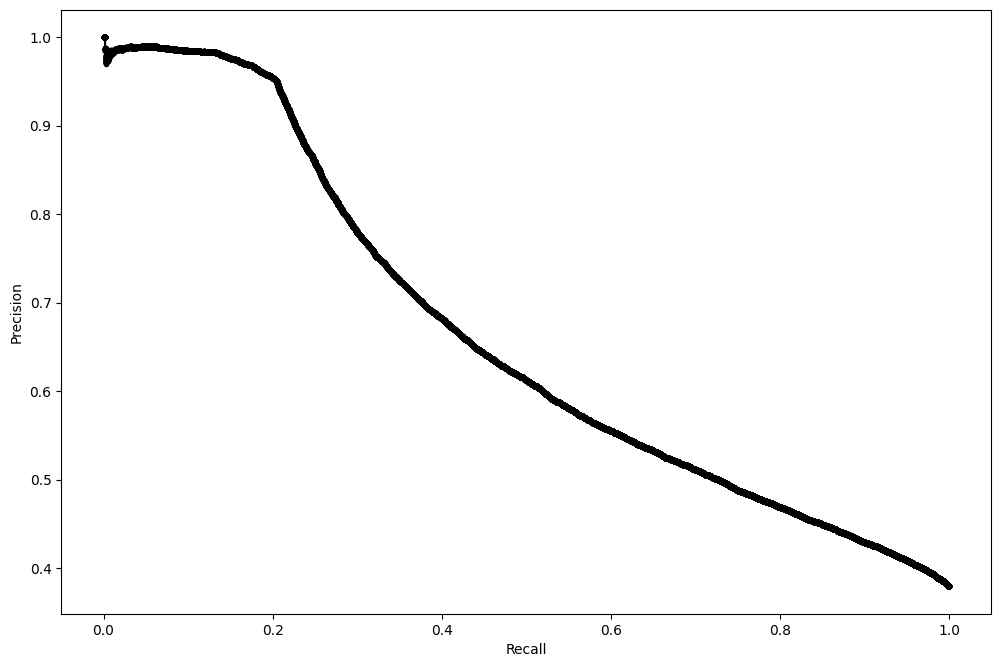

In [5]:
np.set_printoptions(threshold=np.inf)

input_t = keras.Input(shape=(250, 250, 3))
base_model = keras.applications.ResNet50(input_tensor=input_t, include_top=False, weights='imagenet') 
base_model.trainable = False



inputs = keras.Input(shape=(250, 250, 3))
x = base_model(inputs, training = False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

model.load_weights('/content/drive/MyDrive/best_model_transfer_noweights.h5')

test_labels = []
test_classes = test_dataset.class_names
for images, labels in test_dataset:
  test_labels.append(labels)
test_labels = np.concatenate(test_labels, axis=0 )
test_labels = test_labels.flatten()



pred = model.predict(test_dataset)

pred = pred.flatten()

precision, recall, thresholds = precision_recall_curve(test_labels, pred)

pyplot.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
pyplot.plot(recall, precision, marker='.', label='Transfer Learning', color = 'k')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')



pred[pred<0.5]=0
pred[pred>=0.5]=1






print(balanced_accuracy_score(test_labels, pred))

print(accuracy_score(test_labels, pred))
print(confusion_matrix(test_labels, pred))
print(precision_score(test_labels, pred))
print(recall_score(test_labels, pred))
print(f1_score(test_labels, pred))
print(fbeta_score(test_labels, pred, beta = 0.5))

